In [1]:
import numpy as np 
import pandas as pd 
import time
import orca 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from statsmodels.discrete.discrete_model import MNLogit

In [2]:
hdf = pd.HDFStore('output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']
acc = hdf['/accessibility/trip_mode_choice']
lu = hdf['/land_use/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  10000
Number of Persons:  24932
Number of tours:  31951
Number of trips:  81773


In [3]:
def simulation(probs):
    rands = np.random.rand(len(probs),1,)
    probs_arr = probs.values.cumsum(axis=1) - rands
    choices = np.argmax(probs_arr > 0.0, axis=1)
    choices = pd.Series(choices, index=probs.index)
    return choices

In [4]:
def car_ownership_validation(hh):
    ''' Validation tool for car ownership model
    Input: Dataframe with columns VEHCL: Real number of vehicles, 
           and 'auto_ownership': predicted household car ownership. 
    Output: Plots of carownership by TAZ. 
    '''
    # Auto ownership by TAZ 
    hh['0'] = hh['auto_ownership'] == 0
    hh['1'] = hh['auto_ownership'] == 1
    hh['2'] = hh['auto_ownership'] == 2
    hh['3'] = hh['auto_ownership'] == 3
    hh['4'] = hh['auto_ownership'] == 4

    auto_asim = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum' })
    auto_asim.reset_index(inplace = True)

    auto_asim = pd.melt(auto_asim, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    #VEHCL by TAZ 
    hh['0'] = hh['VEHICL'] == 0
    hh['1'] = hh['VEHICL'] == 1
    hh['2'] = hh['VEHICL'] == 2
    hh['3'] = hh['VEHICL'] == 3
    hh['4'] = hh['VEHICL'] >= 4

    auto_tm1 = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum', })
    auto_tm1.reset_index(inplace = True)

    auto_tm1 = pd.melt(auto_tm1, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    # Merge ativitysim and validation results in one table
    auto = auto_asim.merge(auto_tm1, how = 'inner', on = ['TAZ', 'variable'], suffixes=('_asim', '_tm1'))
    auto.columns = ['TAZ', 'Auto ownership', 'ActivitySim', 'MTC']
    
    #Plot
    g = sns.lmplot('MTC','ActivitySim', auto,col = 'Auto ownership',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})

    g.fig.suptitle("TAZ-to-TAZ Car ownerwhip \n MTC vs ActivitySim", y=1.05, fontsize = 15);

In [174]:
def add_simulation_vars(households, accessibilities, land_use):
    
    #Merge accesibilities and land use variables 
    hh_merge = hh.merge(accessibilities, how = 'inner', left_on = 'TAZ', right_index = True).\
              merge(land_use, how = 'inner', left_on = 'TAZ', right_index = True)
    
    #Household-based variables 
    hh_merge['num_drivers_2'] = hh_merge.num_drivers == 2
    hh_merge['num_drivers_3'] = hh_merge.num_drivers == 3
    hh_merge['num_drivers_4+'] = hh_merge.num_drivers > 3
    hh_merge['children_0_4'] = hh_merge.num_young_children > 0
    hh_merge['children_5_17'] = (hh_merge.num_children_5_to_15 + hh_merge.num_children_16_to_17)>0
    hh_merge['num_workes_3'] = hh_merge.num_workers.clip(upper = 3)
    hh_merge['income_30'] = hh_merge.income_in_thousands.clip(0,30)
    hh_merge['income_75'] = (hh_merge.income_in_thousands-30).clip(0,45)
    hh_merge['income_125'] = (hh_merge.income_in_thousands-75).clip(0,50)
    
    #Household and land_use-based variables 
    hh_merge['density_10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['density_10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['constant'] = 1
    
    #Accessibility_based variables
    hh_merge['retail_0w_auto'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_+1w_auto'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_0w_transit'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_+1w_transit'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_0w_nm'] = (hh_merge.num_workers == 0)*hh_merge.nmRetail
    hh_merge['retail_+1w_nm'] = (hh_merge.num_workers > 0)*hh_merge.nmRetail
    hh_merge['auto_saving_work'] = np.where(hh_merge.num_workers > 0, 
                                      hh_merge.hh_work_auto_savings_ratio/hh_merge.num_workers, 
                                      0)
    
    hh_merge['cars'] = hh_merge.VEHICL.where(hh_merge.VEHICL < 4, 4)
    return hh_merge

In [178]:
variables = ['constant',
             'num_drivers_2', 'num_drivers_3', 'num_drivers_4+', 'num_children_16_to_17',
             'num_college_age', 'num_young_adults', 'children_0_4', 'children_5_17',
             'num_workes_3', 'income_30', 'income_75', 'income_125', 'density_10_0w',
#              'density_+10_0w', 
             'density_10_+1w', 
#              'density_+10_+1w',
             'retail_0w_auto','retail_+1w_auto', 
#              'retail_0w_transit','retail_+1w_transit', 
             'retail_0w_nm', 
             'retail_+1w_nm',
#              'auto_saving_work', 
             'cars'
            ]

In [179]:
hh_merge = add_simulation_vars(hh, acc, lu) 

# Train and test set

In [180]:
#Splitting the data
df = hh_merge[variables].astype(float)
x = df.drop(['cars'], axis = 1)
y = df.loc[:,'cars']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

## Multinomial Model 

In [181]:
model = MNLogit(y_train, X_train)
result = model.fit()
result.summary().add_table_params

Optimization terminated successfully.
         Current function value: 0.897866
         Iterations 8


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
Dep. Variable:                   cars   No. Observations:                 6700
Model:                        MNLogit   Df Residuals:                     6624
Method:                           MLE   Df Model:                           72
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:                  0.2821
Time:                        01:50:50   Log-Likelihood:                -6015.7
converged:                       True   LL-Null:                       -8379.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
               cars=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
constant                  4.2694      1.095      3.899      0.000       2.123       6.415
num_driv

## Model calibration 

For this part, I will try to recreate the model of the simulation, so I don't have to simulate everytime to try a new thing. Everytime I simulate I spent about 10 minutes, and I am sure I will want to do many trials before choosing the right option. 

To recreate the model I need: 
- Read auto_ownership_simulate.csv because this file contains the estimated parameters 
- Calculate variables needed for the model (This is almost done) 
- Cross product of variables and parameters to obtain utilities 
- Transform utilities in probabilities 
- Montecarlo simulation to predict choice (thios fuction is already done above). 

In [46]:
# Read csv file 
coeff = pd.read_csv('configs/auto_ownership.csv')
coeff = coeff.fillna(0)[['cars0', 'cars1', 'cars2', 'cars3', 'cars4']]

var_names = ['num_drivers_2', 'num_drivers_3', 'num_drivers_4+', 'num_children_16_to_17',
             'num_college_age', 'num_young_adults', 'children_0_4', 'children_5_17',
             'num_workes_3', 'income_30', 'income_75', 'income_125', 'density_10_0w',
             'density_+10_0w','density_10_+1w', 'density_+10_+1w','constant', 
             'retail_0w_auto','retail_+1w_auto', 'retail_0w_transit','retail_+1w_transit', 
             'retail_0w_nm', 'retail_+1w_nm', 'auto_saving_work']

coeff.index = var_names

CPU times: user 17.9 s, sys: 411 ms, total: 18.3 s
Wall time: 2.74 s


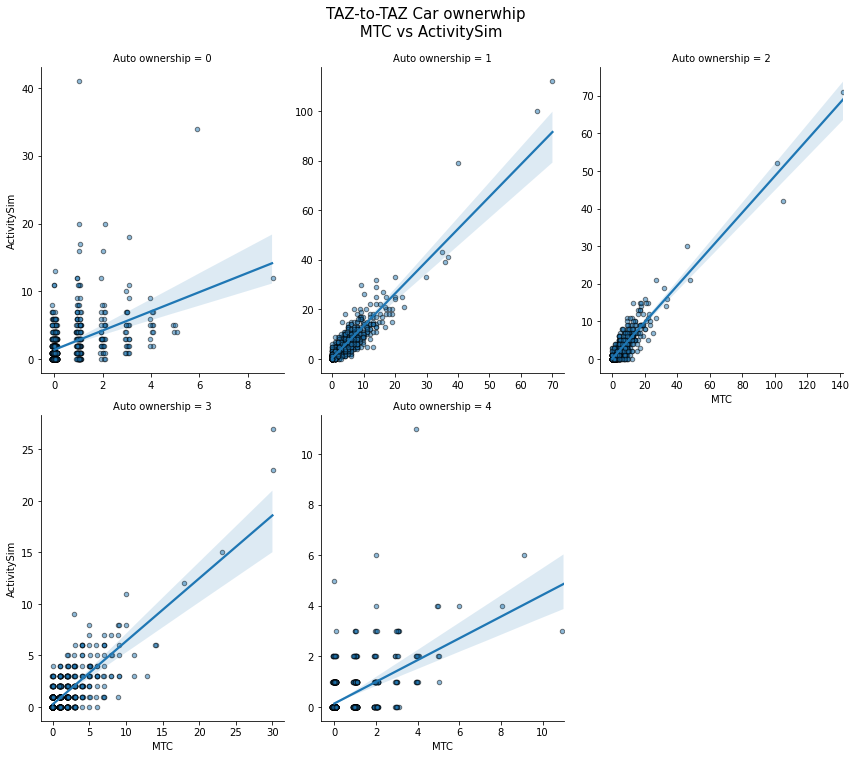

In [47]:
%%time
hh_merge = add_simulation_vars(hh, acc, lu) 
utils = (coeff.T @ hh_merge[var_names].T).T.astype(float)
utils_exp = utils.apply(np.exp)
probs = utils_exp.div(utils_exp.sum(axis = 1), axis = 0)
choices = simulation(probs)
hh_merge['auto_ownership'] = choices 
car_ownership_validation(hh_merge)

In [48]:
#Cross tab
cross_tab = pd.crosstab(hh_merge.VEHICL_1, hh_merge.auto_ownership)
accuracy = np.sum(np.diagonal(np.array(cross_tab)))/10000
score = np.abs((hh_merge.VEHICL_1.value_counts() -  hh_merge.auto_ownership.value_counts())).sum()
print('accuracy: ',accuracy*100)
print('Number of misclassified categories:', score)

accuracy:  40.129999999999995
Number of misclassified categories: 5248


## Grid search 
This part will take care of the grid search
- Create arrays for each parameter that will be included in the serach 
- Create an array that contains all posible combonations of the parameters
- Select random combinations (All combinations take a lot to run) 
- Run simulation with random set of coefficients and store score result
- Organize scores in a table to compare results

### Experimenting variables and constants at the same time 

In [157]:
#Parameter values ranges ## FINAL VALUES
constant_1_value = np.linspace(3.4,3.5,11)
constant_2_value = np.linspace(1.6,1.7,11)
constant_3_value = np.linspace(-0.9,-0.8,11)
constant_4_value = np.linspace(-3.3,-3.2,11)

num_drive_2_1 = np.linspace(0.35,0.45,11)
num_drive_3_1 = np.linspace(0,0.5,11)
num_children_16_to_17_1 = np.linspace(0.3,0.5,11)
num_young_adults = np.linspace(0.8,1.0,11)

In [170]:
#Parameter values ranges
constant_1_value = np.linspace(-5,5,11)
constant_2_value = np.linspace(-5,5,11)
constant_3_value = np.linspace(-5,5,11)
constant_4_value = np.linspace(-5,5,11)

num_drive_2_1 = np.linspace(-1,1,11)
num_drive_3_1 = np.linspace(-1,1,11)
num_children_16_to_17_1 = np.linspace(-1,1,11)
num_young_adults = np.linspace(-1,1,11)

In [188]:
#Building grid of coefficients: 
grid = np.array(np.meshgrid(constant_1_value, 
                            constant_2_value, 
                            constant_3_value, 
                            constant_4_value,
                            num_drive_2_1, 
                            num_drive_3_1, 
                            num_children_16_to_17_1, 
                            num_young_adults)).T.reshape(-1,8)

#Obtain random combination set of parameters. 
grid_rands = grid[np.random.randint(grid.shape[0], size=500), :]

In [189]:
%%time
score_list = []
for row in grid_rands:
#     start = time.time()
    coeff.loc['constant','cars1'] = row[0]
    coeff.loc['constant','cars2'] = row[1]
    coeff.loc['constant','cars3'] = row[2]
    coeff.loc['constant','cars4'] = row[3]
    coeff.loc['num_drivers_2','cars1'] = row[4]
    coeff.loc['num_drivers_3','cars1'] = row[5]
    coeff.loc['num_children_16_to_17','cars1'] = row[6]
    coeff.loc['num_young_adults','cars1'] = row[7]
    
    utils = (coeff.T @ hh_merge[var_names].T).T.astype(float)
    utils_exp = utils.apply(np.exp)
    probs = utils_exp.div(utils_exp.sum(axis = 1), axis = 0)
    choices = simulation(probs)
    hh_merge['auto_ownership'] = choices 
    
    #Cross tab
    cross_tab = pd.crosstab(hh_merge.VEHICL, hh_merge.auto_ownership, normalize= 'all')
    score = np.diagonal(cross_tab).sum()
    score_list.append(score)
#     score = np.abs((hh_merge.VEHICL_1.value_counts() -  hh_merge.auto_ownership.value_counts())).sum()
#     score_list.append(score)
#     end = time.time()
#     print(end - start)

CPU times: user 11.9 s, sys: 20 ms, total: 11.9 s
Wall time: 11.9 s


In [190]:
results_join = pd.DataFrame(grid_rands)
results_join['score'] = score_list
results_join

,0,1,2,3,4,5,6,7,score
0,3.0,0.0,-5.0,-5.0,-0.8,0.6,0.4,0.2,0.4777
1,-5.0,4.0,-4.0,2.0,-0.2,-0.8,-1.0,1.0,0.3274
2,3.0,0.0,-3.0,5.0,1.0,1.0,-1.0,-0.4,0.0537
3,-3.0,5.0,-5.0,-2.0,-1.0,0.8,1.0,0.4,0.3442
4,-4.0,1.0,5.0,-3.0,0.6,-0.6,0.4,-0.6,0.1343
5,0.0,-5.0,3.0,1.0,-0.2,-1.0,-0.4,0.2,0.3975
6,2.0,4.0,-2.0,-1.0,0.4,-0.4,0.8,0.6,0.4479
7,4.0,1.0,-3.0,1.0,-0.8,-0.8,-0.8,-0.2,0.3159
8,1.0,-1.0,-5.0,2.0,-1.0,1.0,-1.0,0.4,0.0791
9,5.0,0.0,5.0,3.0,0.0,0.4,-0.2,1.0,0.2072


In [191]:
results_join.score.max()

0.4777

In [192]:
results_join[results_join.score > 0.5]

,0,1,2,3,4,5,6,7,score
